# UK testing notebook

This notebook includes testing for the functionality of reweight with PolicyEngine UK.

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

In [1]:
from policyengine_uk import Microsimulation
from policyengine_uk.data import RawFRS_2021_22
RawFRS_2021_22().download()

In [3]:
from policyengine_uk.data.datasets.frs.calibration.calibrate import generate_model_variables

(
    household_weights,
    weight_adjustment,
    values_df,
    targets,
    targets_array,
    equivalisation_factors_array
) = generate_model_variables("frs_2021", 2025)

In [4]:
from reweight import reweight

In [5]:
sim_matrix = torch.tensor(values_df.to_numpy(), dtype=torch.float32)

final_weights = reweight(household_weights, sim_matrix, targets, targets_array)

Epoch 100, Loss: 48.30685043334961
Epoch 200, Loss: 40.58155059814453
Epoch 300, Loss: 34.585235595703125
Epoch 400, Loss: 29.832853317260742
Epoch 500, Loss: 25.99891471862793
Epoch 600, Loss: 22.858182907104492
Epoch 700, Loss: 20.250896453857422
Epoch 800, Loss: 18.061073303222656
Epoch 900, Loss: 16.202829360961914
Epoch 1000, Loss: 14.611446380615234


In [6]:
def nonzero_proportion(tensor):
    return torch.count_nonzero(tensor).item() / tensor.numel()

print(nonzero_proportion(household_weights))

print(nonzero_proportion(final_weights))

1.0
1.0


In [7]:
import matplotlib.pyplot as plt

def plot_tensor_histogram(tensor, bins=30, title='Tensor Histogram'):
    # Flatten the tensor to 1D
    flattened = tensor.flatten()
    
    # Convert to numpy array for matplotlib
    data = flattened.numpy()
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    
    # Show the plot
    plt.show()

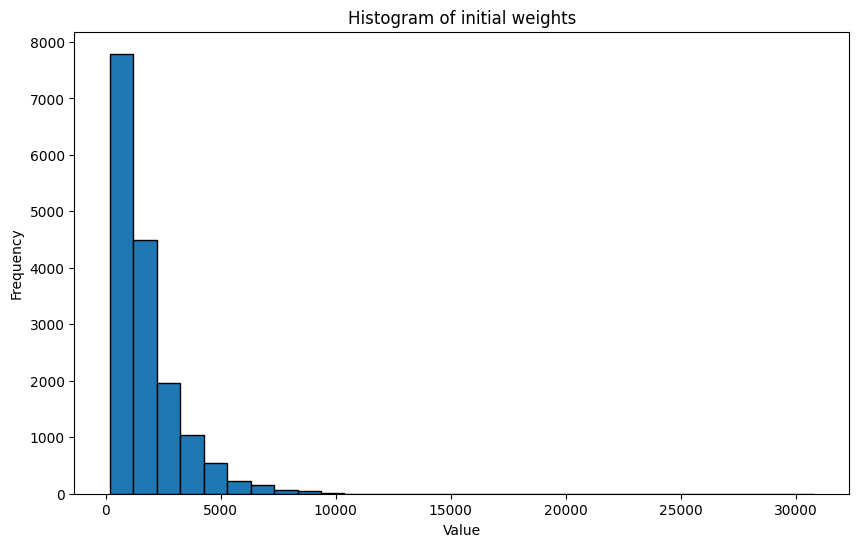

In [9]:
plot_tensor_histogram(household_weights, title="Histogram of initial weights")

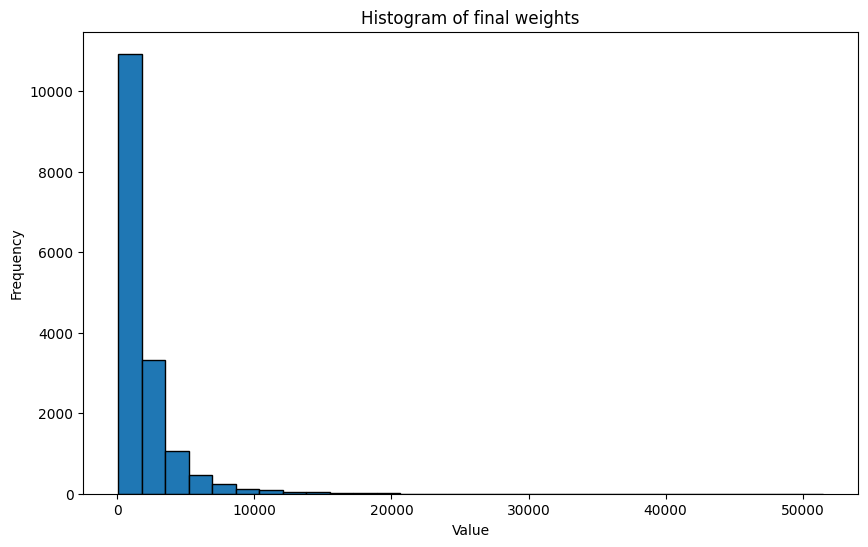

In [10]:
plot_tensor_histogram(final_weights, title="Histogram of final weights")